Time Independent SE for sech^2 Potential

Found 1000 total states.
Found 6 bound states.
Bound State Energies (E < 0):
E_0 = -17.0782
E_1 = -11.7351
E_2 = -7.3921
E_3 = -4.0484
E_4 = -1.7038
E_5 = -0.3581


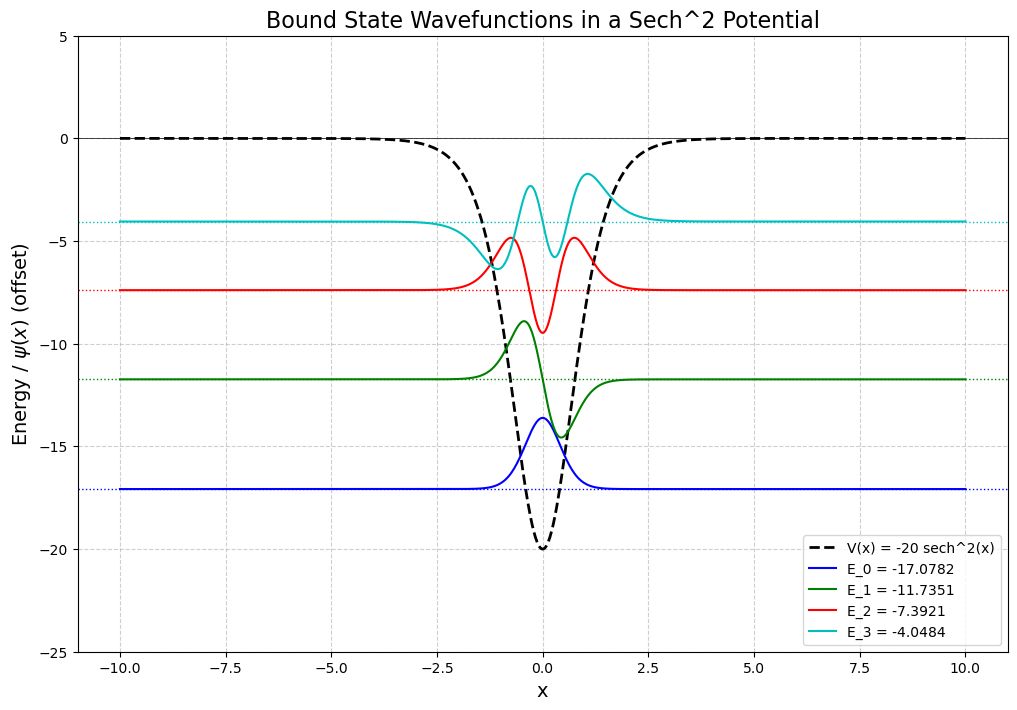

In [4]:
#
# Python code to solve the TISE for the Sech^2 Potential
#
# We solve the equation: -hbar^2/(2m) * psi'' + V(x) * psi = E * psi
#
# This script uses the finite-difference method to turn the differential
# equation into a matrix eigenvalue problem, which is then solved numerically.
#

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# 1. Set Parameters and Constants
# We use simple units: hbar = 1, m = 1 (so 2m = 2)
hbar = 1
m = 1

# Potential depth
V0 = 20

# Spatial grid
N = 1000  # Number of grid points
L = 10.0   # Solve from -L to +L
x = np.linspace(-L, L, N)
dx = x[1] - x[0]  # Grid spacing

# 2. Define the Potential
def V(x):
    return -V0 / (np.cosh(x)**2)

potential = V(x)

# 3. Construct the Hamiltonian Matrix
# We approximate the second derivative (Laplacian) as:
# psi''(x_i) approx (psi_{i+1} - 2*psi_i + psi_{i-1}) / dx^2
#
# The TISE becomes:
# -hbar^2/(2m) * (psi_{i+1} - 2*psi_i + psi_{i-1}) / dx^2 + V_i * psi_i = E * psi_i
#
# This is a tridiagonal matrix equation.
#
# Diagonal elements:
diag = (hbar**2 / (m * dx**2)) + potential

# Off-diagonal elements:
offdiag = -hbar**2 / (2 * m * dx**2) * np.ones(N - 1)

# 4. Solve the Eigenvalue Problem
# We build the full Hamiltonian matrix H
# H is symmetric tridiagonal
H_matrix = np.diag(diag) + np.diag(offdiag, k=1) + np.diag(offdiag, k=-1)

# eigh solves the eigenvalue problem for a symmetric matrix
# It returns eigenvalues (energies) and eigenvectors (wavefunctions)
energies, wavefunctions = eigh(H_matrix)

# 5. Process and Plot Results

print(f"Found {len(energies)} total states.")

# Get the bound states (E < 0)
bound_indices = np.where(energies < 0)[0]
num_bound_states = len(bound_indices)

print(f"Found {num_bound_states} bound states.")
print("Bound State Energies (E < 0):")
for i in bound_indices:
    print(f"E_{i} = {energies[i]:.4f}")

# Plot the potential and the first few bound state wavefunctions
plt.figure(figsize=(12, 8))

# Plot the potential
plt.plot(x, potential, 'k--', label=f'V(x) = -{V0} sech^2(x)', linewidth=2)

# Plot the wavefunctions
# We'll plot the first 4 bound states for clarity
plot_limit = min(num_bound_states, 4)
colors = ['b', 'g', 'r', 'c', 'm', 'y']

for i in range(plot_limit):
    # Get the correct eigenvector
    psi = wavefunctions[:, bound_indices[i]]
    
    # Normalize for plotting
    # (scipy.linalg returns L2-normalized vectors)
    # We can scale them for better visibility
    # A simple way is to shift them by their energy
    amplitude_scale = 3  # Arbitrary scaling for plotting
    psi_normalized = psi / np.sqrt(np.sum(psi**2) * dx) # Re-normalize
    
    # Plot wavefunction offset by its energy
    plt.plot(x, amplitude_scale * psi_normalized + energies[bound_indices[i]],
             label=f'E_{i} = {energies[bound_indices[i]]:.4f}',
             color=colors[i],
             linewidth=1.5)

# Add horizontal lines for energy levels
for i in range(plot_limit):
    plt.axhline(energies[bound_indices[i]], color=colors[i], linestyle=':', linewidth=1)

# Final plot formatting
plt.title('Bound State Wavefunctions in a Sech^2 Potential', fontsize=16)
plt.xlabel('x', fontsize=14)
plt.ylabel(r'Energy / $\psi(x)$ (offset)', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(-V0 - 5, 5) # Set y-axis limits
plt.axhline(0, color='black', linewidth=0.5) # x-axis
plt.show()



Quantum Simulation of GWP in Elliptical Boundary

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.sparse import identity, lil_matrix
from scipy.sparse.linalg import factorized
from tqdm import tqdm
import time
import matplotlib.patches as mpatches

# ----------------------------
# Create main output directory
# ----------------------------
output_dir = "Quantum Dynamics"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created main directory: {output_dir}")
else:
    print(f"Main directory already exists: {output_dir}")

# ----------------------------
# Initial conditions list
# ----------------------------
initial_conditions = [
    (-15.0, -5.0, 3.0, 5.0, 1.5),
    (-10.0, 0.0, 2.0, 4.0, 1.2),
    (-5.0, 5.0, 4.0, 3.0, 1.0),
]

# ----------------------------
# Stadium parameters
# ----------------------------
a, b, rx, ry = 20.0, 10.0, 5.0, 10.0
Nx, Ny = 600, 600
x = np.linspace(-a-rx, a+rx, Nx)
y = np.linspace(-b-ry, b+ry, Ny)
dx, dy = x[1]-x[0], y[1]-y[0]
X, Y = np.meshgrid(x, y, indexing='ij')

# ----------------------------
# Mask and index mapping
# ----------------------------
def is_inside_stadium(x, y, a, b, rx, ry):
    if -a <= x <= a:
        return abs(y) <= b
    elif x > a:
        return ((x - a)**2)/(rx**2) + (y**2)/(ry**2) <= 1.0
    else:
        return ((x + a)**2)/(rx**2) + (y**2)/(ry**2) <= 1.0

mask = np.vectorize(is_inside_stadium)(X, Y, a, b, rx, ry)
mask_flat = mask.flatten()
inside_idx = np.where(mask_flat)[0]
N_inside = len(inside_idx)
idx_map = -np.ones(mask_flat.shape, dtype=int)
idx_map[inside_idx] = np.arange(N_inside)

# ----------------------------
# Gaussian wavepacket
# ----------------------------
def gaussian_wavepacket(X, Y, x0, y0, px0, py0, sigma):
    # Set hbar=1
    return (1/(sigma*np.sqrt(np.pi))) * np.exp(-((X-x0)**2 + (Y-y0)**2)/(2*sigma**2)) * np.exp(1j*(px0*X + py0*Y))

# ----------------------------
# Laplacian matrix
# ----------------------------
t0 = time.time()
from scipy.sparse import csc_matrix
L = lil_matrix((N_inside, N_inside), dtype=float)
c_center = -2.0/dx**2 - 2.0/dy**2
cx = 1.0/dx**2
cy = 1.0/dy**2
for i in range(Nx):
    base = i*Ny
    for j in range(Ny):
        global_idx = base+j
        if not mask[i, j]: continue
        row = idx_map[global_idx]; L[row, row] = c_center
        if i-1>=0 and mask[i-1,j]: L[row, idx_map[(i-1)*Ny+j]] = cx
        if i+1<Nx and mask[i+1,j]: L[row, idx_map[(i+1)*Ny+j]] = cx
        if j-1>=0 and mask[i,j-1]: L[row, idx_map[i*Ny+(j-1)]] = cy
        if j+1<Ny and mask[i,j+1]: L[row, idx_map[i*Ny+(j+1)]] = cy
L = L.tocsc()


print(f"Laplacian built in {time.time()-t0:.2f}s, nnz={L.nnz}")

# ----------------------------
# Crank-Nicolson operator (with H = -1/2 * L, assuming m=1, hbar=1)
# ----------------------------
dt = 0.05
I_inside = identity(N_inside, dtype=complex)
A = (I_inside - 0.25j*dt*L).tocsc()
B = (I_inside + 0.25j*dt*L).tocsc()
solve = factorized(A)
nsteps, frame_skip = 800, 6

# ----------------------------
# Boundary & classical functions
# ----------------------------
def boundary_normal(x, y, a, b, rx, ry):
    eps = 1e-9
    if abs(abs(y)-b) < 1e-8 and -a-1e-8 <= x <= a+1e-8: 
        return np.array([0.0, -1.0]) if y>0 else np.array([0.0, 1.0])
    val_right = ((x - a)**2)/(rx**2) + (y**2)/(ry**2)
    if abs(val_right-1.0)<1e-6 and x>=a-1e-6:
        gx, gy = 2.0*(x-a)/rx**2, 2.0*y/ry**2
        nin=-np.array([gx,gy]); nrm=np.linalg.norm(nin); return nin/max(nrm,eps)
    val_left = ((x + a)**2)/(rx**2) + (y**2)/(ry**2)
    if abs(val_left-1.0)<1e-6 and x<=-a+1e-6:
        gx, gy = 2.0*(x+a)/rx**2, 2.0*y/ry**2
        nin=-np.array([gx,gy]); nrm=np.linalg.norm(nin); return nin/max(nrm,eps)
    dtop, dbot, dright, dleft = abs(y-b), abs(y+b), abs(val_right-1.0), abs(val_left-1.0)
    mind = min(dtop, dbot, dright, dleft)
    if mind==dtop: return np.array([0.0,-1.0])
    if mind==dbot: return np.array([0.0,1.0])
    if mind==dright: gx, gy=2.0*(x-a)/rx**2,2.0*y/ry**2; nin=-np.array([gx,gy]); return nin/np.linalg.norm(nin)
    gx, gy=2.0*(x+a)/rx**2,2.0*y/ry**2; nin=-np.array([gx,gy]); return nin/np.linalg.norm(nin)

def reflect_velocity(v, n_inward):
    return v - 2.0 * np.dot(v, n_inward) * n_inward

def find_collision_time_between(x, v, dt, a, b, rx, ry):
    x_end = x + v*dt
    if is_inside_stadium(x_end[0], x_end[1], a, b, rx, ry): return False, None, None
    t_lo, t_hi = 0.0, dt
    def inside_at(t): return is_inside_stadium(*(x+v*t), a, b, rx, ry)
    if not inside_at(t_lo): return True, 0.0, x.copy()
    if inside_at(t_hi): return False, None, None
    for _ in range(50):
        tm = 0.5*(t_lo+t_hi)
        if inside_at(tm): t_lo=tm
        else: t_hi=tm
    t_collision = 0.5*(t_lo+t_hi)
    return True, t_collision, x + v*t_collision

def integrate_particle(x0, v0, a, b, rx, ry, dt, T):
    nsteps=int(np.ceil(T/dt)); t,x,v=0.0,x0.copy(),v0.copy()
    times, positions, velocities=[0.0],[x.copy()],[v.copy()]
    for step in range(nsteps):
        remaining_dt, subiter = dt, 0
        while remaining_dt>1e-12 and subiter<20:
            subiter+=1
            collided,tcol,_ = find_collision_time_between(x,v,remaining_dt,a,b,rx,ry)
            if not collided: x+=v*remaining_dt; t+=remaining_dt; remaining_dt=0.0; break
            else:
                if tcol<1e-14: n=boundary_normal(x[0],x[1],a,b,rx,ry); v=reflect_velocity(v,n); x+=v*1e-10; continue
                x+=v*tcol; t+=tcol; remaining_dt-=tcol; n=boundary_normal(x[0],x[1],a,b,rx,ry); v=reflect_velocity(v,n)
        times.append(t); positions.append(x.copy()); velocities.append(v.copy())
    return np.array(times), np.array(positions), np.array(velocities)

# ----------------------------
# Loop over runs
# ----------------------------
for run_idx, (x0, y0, px0, py0, sigma) in enumerate(initial_conditions, start=1):
    run_label = f"Run {run_idx}"
    output_subdir = os.path.join(output_dir, f"Run_{run_idx}")
    if not os.path.exists(output_subdir):
        os.makedirs(output_subdir)
        print(f"Created subdirectory: {output_subdir}")
    else:
        print(f"Subdirectory already exists: {output_subdir}")

    # Initial wavepacket
    psi0 = gaussian_wavepacket(X, Y, x0, y0, px0, py0, sigma)
    psi0[~mask] = 0.0
    norm0 = np.sqrt(np.sum(np.abs(psi0)**2)*dx*dy)
    psi0/=norm0
    psi_inside = psi0.flatten()[inside_idx].astype(complex)

    # Time evolution
    frames, times_list, norms = [], [], []
    expect_x, expect_y = [], []

    for step in tqdm(range(nsteps), desc=f"Simulating {run_label}"):
        psi_inside = solve(B.dot(psi_inside))
        psi_full = np.zeros(mask_flat.shape, dtype=complex)
        psi_full[inside_idx]=psi_inside
        psi_2d = psi_full.reshape((Nx, Ny))
        
        prob_density=np.abs(psi_2d)**2
        norm = np.sum(prob_density)*dx*dy # Norm is sum, not sqrt of sum
        norms.append(norm)

        # Normalize norm to 1 to prevent numerical drift in expectation values
        norm_factor = norm if norm > 1e-9 else 1.0

        expect_x.append(np.sum(prob_density*X)*dx*dy / norm_factor)
        expect_y.append(np.sum(prob_density*Y)*dx*dy / norm_factor)
        times_list.append(step*dt)

        if step % frame_skip == 0: frames.append(prob_density.copy())

    expect_x = np.array(expect_x); expect_y = np.array(expect_y)
    

    # Classical trajectory
    x0_classical = np.array([x0,y0],float)
    v0_classical = np.array([px0,py0],float) # m=1
    T_total = nsteps*dt
    classical_times, classical_positions, classical_velocities = integrate_particle(
        x0_classical, v0_classical, a,b,rx,ry,dt,T_total)

    # ----------------------------
    # Save static plots
    # ----------------------------
    # Trajectories
    plt.figure(figsize=(8,8))
    plt.contour(X, Y, mask.astype(int), levels=[0.5], colors='k', linewidths=1.5)
    plt.plot(expect_x, expect_y, '-', color='red', lw=2.5, label=r'Quantum $\langle \mathbf{r} \rangle$')
    plt.plot(classical_positions[:,0], classical_positions[:,1], '--', color='blue', lw=1.8, label='Classical trajectory')
    plt.scatter([classical_positions[0,0]], [classical_positions[0,1]], s=80, marker='s', color='blue', edgecolor='k', label='Start Point')
    plt.scatter([classical_positions[-1,0]], [classical_positions[-1,1]], s=80, marker='D', color='blue', edgecolor='k', label='Classical End Point')
    plt.scatter([expect_x[-1]], [expect_y[-1]], s=80, marker='X', color='red', edgecolor='k', label='Quantum End Point')
    plt.gca().set_aspect('equal', 'box')
    plt.xlabel('x'); plt.ylabel('y'); plt.title(f'Comparison of Trajectories for {run_label}')
    plt.legend()
    plt.tight_layout()
    trajectory_file = os.path.join(output_subdir, f"stadium_trajectory_comparison_{run_label.replace(' ','_')}.png")
    plt.savefig(trajectory_file)
    plt.close()
    print(f"Saved trajectory plot: {trajectory_file}")

    # Norm
    plt.figure(figsize=(8,4)); plt.plot(np.arange(nsteps)*dt, norms, 'b-', lw=2)
    plt.xlabel("Time"); plt.ylabel(r"$||\psi||^2$"); plt.title(f"Quantum Norm vs Time ({run_label})"); plt.grid(alpha=0.3)
    plt.tight_layout()
    norm_file = os.path.join(output_subdir, f"norm_vs_time_{run_label.replace(' ','_')}.png")
    plt.savefig(norm_file)
    plt.close()
    print(f"Saved norm plot: {norm_file}")

    # Classical speed
    speed_classical = np.linalg.norm(classical_velocities, axis=1)
    plt.figure(figsize=(8,4)); plt.plot(classical_times, speed_classical, 'r-', lw=2)
    plt.xlabel("Time"); plt.ylabel("$|v|$"); plt.title(f"Classical Speed vs Time ({run_label})"); plt.grid(alpha=0.3)
    plt.tight_layout()
    speed_file = os.path.join(output_subdir, f"classical_speed_{run_label.replace(' ','_')}.png")
    plt.savefig(speed_file)
    plt.close()
    print(f"Saved classical speed plot: {speed_file}")


    # ----------------------------
    # Animation
    # ----------------------------
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
    vmax = np.max(frames[0]) if len(frames) > 0 and np.max(frames[0]) > 0 else 1.0
    im = ax1.imshow(frames[0].T, extent=[x[0],x[-1],y[0],y[-1]], origin='lower', cmap='hot', vmin=0, vmax=vmax, aspect='auto')
    ax1.contour(X.T, Y.T, mask.T, levels=[0.5], colors='white', linewidths=1.2, alpha=0.9)
    ax1.set_title('Probability density'); ax1.set_xlabel('x'); ax1.set_ylabel('y')
    cbar = fig.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
    cbar.set_label(r'Probability density $|\psi|^2$', rotation=90, labelpad=10)

    line_quantum, = ax2.plot([], [], '-', color='red', lw=2.5, label=r'Quantum $\langle \mathbf{r} \rangle$')
    line_classical, = ax2.plot([], [], '--', color='blue', lw=1.8, label='Classical trajectory')
    patch_prob = mpatches.Patch(color='gray', alpha=0.5, label=r'Probability density $|\psi|^2$')

    ax2.scatter([classical_positions[0,0]], [classical_positions[0,1]], s=70, marker='s', color='blue', edgecolor='k', zorder=6, label='Start Point')
    ax2.contour(X.T, Y.T, mask.T, levels=[0.5], colors='k', linewidths=1.2)

    ax2.set_xlim(x[0], x[-1]); ax2.set_ylim(y[0], y[-1])
    ax2.set_xlabel('x'); ax2.set_ylabel('y'); ax2.set_title(f'Evolution of Trajectories in {run_label}')
    ax2.legend(handles=[patch_prob, line_quantum, line_classical], loc='upper right')
    ax2.set_aspect('equal', 'box')

    n_frames = len(frames)
    def animate(frame_idx):
        prob = frames[frame_idx]
        im.set_array(prob.T)
        im.set_clim(0, prob.max() if prob.max()>0 else vmax)
        step_idx = min(frame_idx*frame_skip, len(expect_x)-1)
        line_quantum.set_data(expect_x[:step_idx+1], expect_y[:step_idx+1])
        current_time = min(step_idx*dt, classical_times[-1])
        mask_c = classical_times <= current_time
        if np.any(mask_c):
            line_classical.set_data(classical_positions[mask_c][:,0], classical_positions[mask_c][:,1])
        else:
            line_classical.set_data([], [])
        return im, line_quantum, line_classical

    ani = FuncAnimation(fig, animate, frames=n_frames, interval=80, blit=False)
    out_filename = os.path.join(output_subdir, f"quantum_classical_stadium_{run_label.replace(' ','_')}.mp4")
    from matplotlib import animation
    try:
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=12, metadata=dict(artist='CN-solver'), bitrate=2500)
        ani.save(out_filename, writer=writer, dpi=200)
        print(f"Saved animation MP4: {out_filename}")
    except Exception as e:
        print(f"FFmpeg failed: {e}, saving GIF instead")
        out_filename = os.path.join(output_subdir, f"quantum_classical_stadium_{run_label.replace(' ','_')}.gif")
        ani.save(out_filename, writer='pillow', fps=8)
        print(f"Saved animation GIF: {out_filename}")
    plt.close(fig)

    print(f"Finished all outputs for {run_label}\n")